## Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## Data

### Load Data

In [98]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")
print(train_data.head())

Train shape: (8693, 14)
Test shape: (4277, 13)
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa       NaN  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2     

In [99]:
print('Missing values (train set):')
print(train_data.isna().sum())
print('')
print('Missing values (test set):')
print(test_data.isna().sum())

Missing values (train set):
PassengerId       0
HomePlanet      201
CryoSleep       218
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Missing values (test set):
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Data types

In [100]:
print('Train set data types:')
print(train_data.dtypes)
print('')
print('Test set data types:')
print(test_data.dtypes)

Train set data types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Test set data types:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object


We need to convert some features to the appropriate data types (int64 or float64) for the model to work properly.

## Data Exploration

### Transported distribution

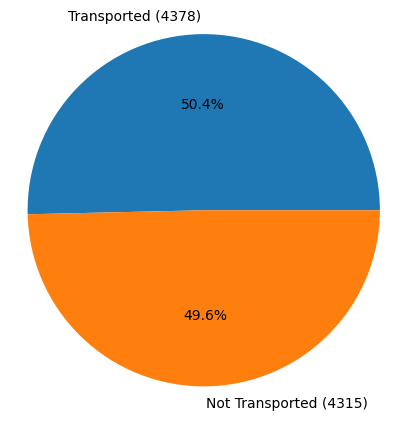

In [101]:
# Figure size
plt.figure(figsize=(5,5))
counts = train_data['Transported'].value_counts()
labels = [f"Transported ({counts[True]})", f"Not Transported ({counts[False]})"]
plt.pie(counts, labels=labels, autopct='%1.1f%%')

plt.axis('equal')
plt.show()

### Expenses distribution

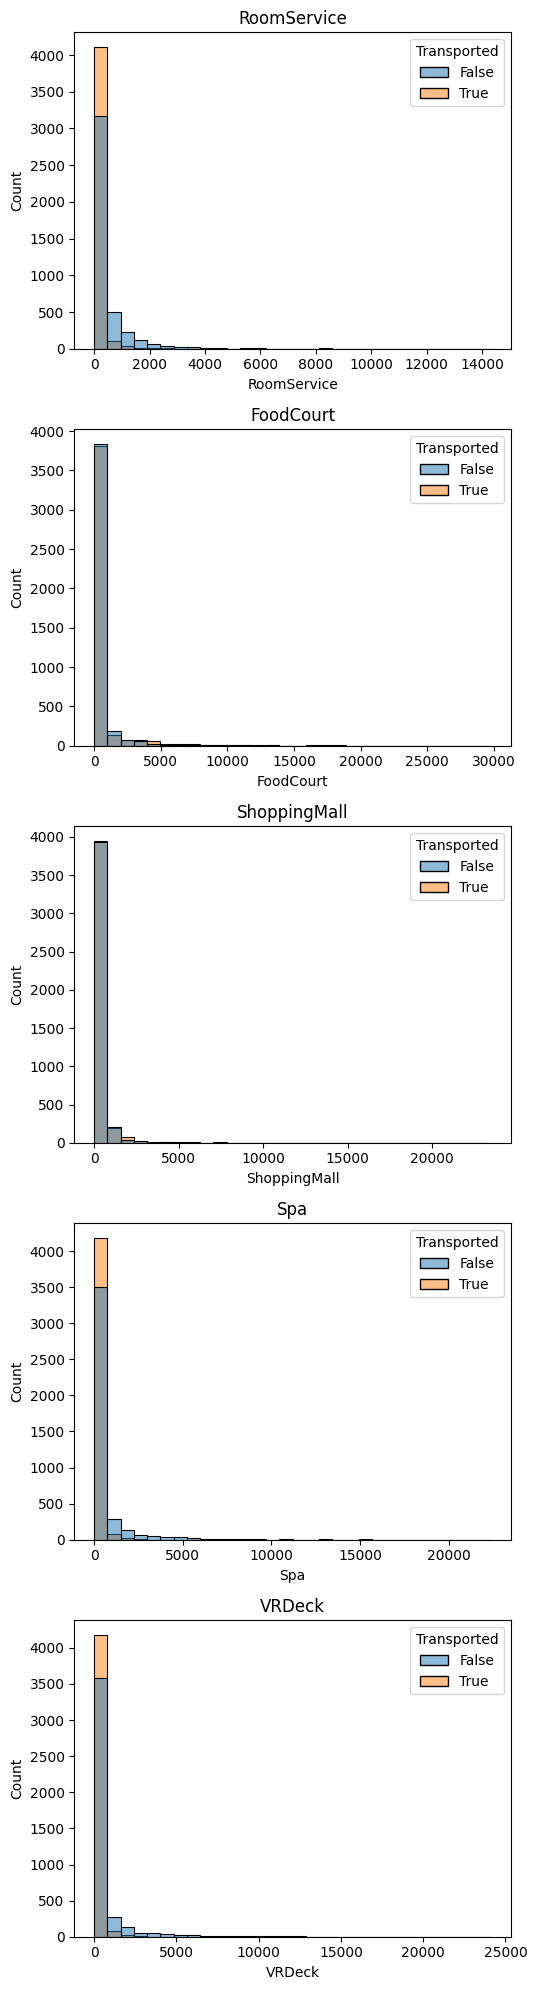

In [102]:
exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure(figsize=(10,20))
for i, feature in enumerate(exp_features):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train_data, x=feature, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(feature)
    
fig.tight_layout()
plt.show()

We notice that most passengers have no expenses. We will create a new feature indicating whether a passenger has expenses or not.

### CryoSleep distribution

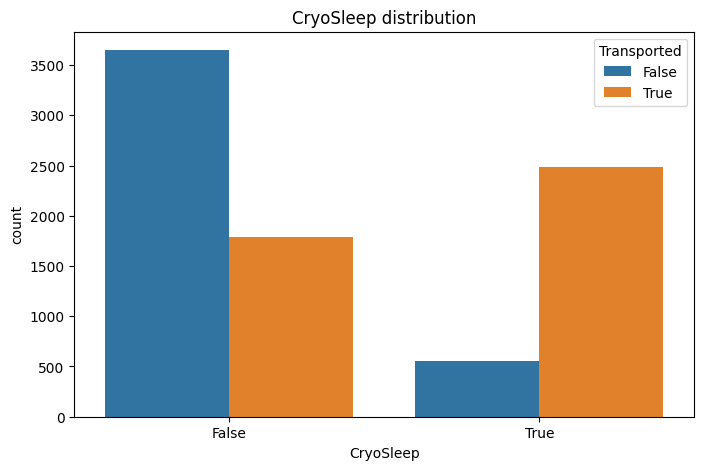

In [103]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='CryoSleep', hue='Transported')
plt.title('CryoSleep distribution')
plt.show()

CryoSleep seems to have an impact on the target variable since most passengers in CryoSleep were transported.

### HomePlanet & Destination distribution

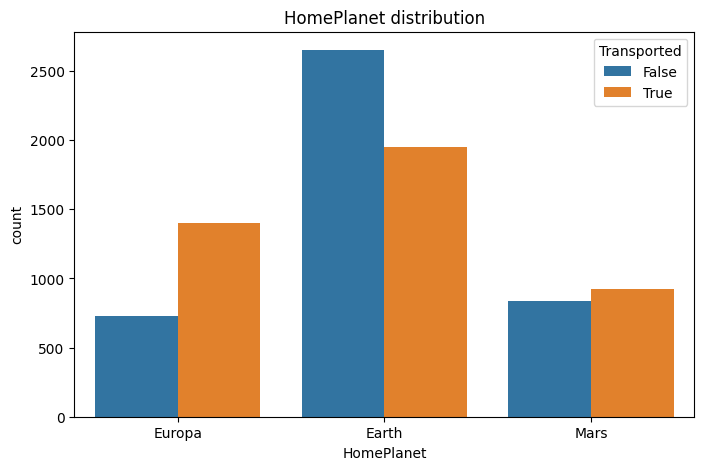

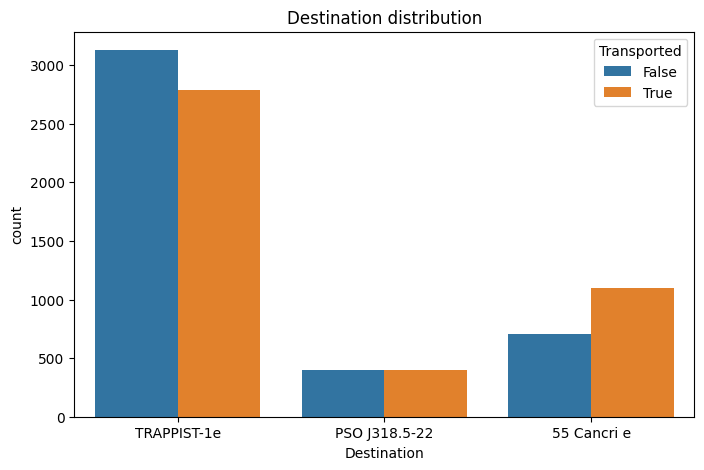

In [104]:
# HomePlanet distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='HomePlanet', hue='Transported')
plt.title('HomePlanet distribution')
plt.show()

# Destination distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='Destination', hue='Transported')
plt.title('Destination distribution')
plt.show()

HomePlanet & Destination do not seem to have a significant impact on the target variable. However, we will keep them for now as they might interact with other features.

### VIP distribution

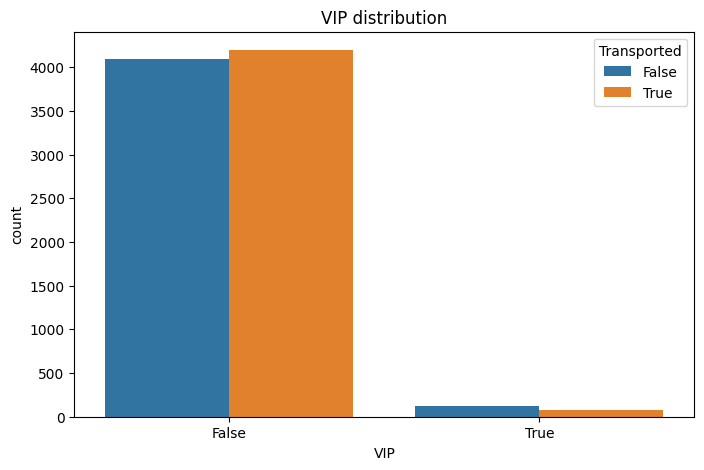

In [105]:
fig = plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='VIP', hue='Transported')
plt.title('VIP distribution')
plt.show()

VIP does not seem to be a significant feature. We will drop it.

### Qualitative features

We can't plot all qualitative features yet because they have too many unique values. We will handle them later.

In [106]:
qualitative_features = ['PassengerId', 'Name', 'Cabin']

print(train_data[qualitative_features].head())

  PassengerId               Name  Cabin
0     0001_01    Maham Ofracculy  B/0/P
1     0002_01       Juanna Vines  F/0/S
2     0003_01      Altark Susent  A/0/S
3     0003_02       Solam Susent  A/0/S
4     0004_01  Willy Santantines  F/1/S


- We can extract the group of a passenger from the PassengerId feature. We will create a new feature indicating the group of a passenger.
- We can extract the deck, num and side of a passenger from the Cabin feature. We will create three new features indicating the deck, num and side of a passenger.
- We can extract the last name of a passenger from the Name feature. We will create a new feature indicating the last name of a passenger.

## Data Cleaning

### Display Missing values

In [107]:
# Missing values summary for train set
print("Train Set Missing Values:")
na_train_cols = train_data.columns[train_data.isna().any()].tolist()
mv_train = pd.DataFrame(train_data[na_train_cols].isna().sum(), columns=['Number_missing'])
mv_train['Percentage_missing'] = np.round(100 * mv_train['Number_missing'] / len(train_data), 2)
print(mv_train)

print("\n" + "="*50 + "\n")

# Missing values summary for test set
print("Test Set Missing Values:")
na_test_cols = test_data.columns[test_data.isna().any()].tolist()
mv_test = pd.DataFrame(test_data[na_test_cols].isna().sum(), columns=['Number_missing'])
mv_test['Percentage_missing'] = np.round(100 * mv_test['Number_missing'] / len(test_data), 2)
print(mv_test)

Train Set Missing Values:
              Number_missing  Percentage_missing
HomePlanet               201                2.31
CryoSleep                218                2.51
Cabin                    199                2.29
Destination              182                2.09
Age                      179                2.06
VIP                      203                2.34
RoomService              181                2.08
FoodCourt                183                2.11
ShoppingMall             208                2.39
Spa                      183                2.11
VRDeck                   188                2.16
Name                     200                2.30


Test Set Missing Values:
              Number_missing  Percentage_missing
HomePlanet                87                2.03
CryoSleep                 93                2.17
Cabin                    100                2.34
Destination               92                2.15
Age                       91                2.13
VIP             

Only 2% of values are missing. However, almost every feature has missing values. We need to handle them.

### Missing values per passenger

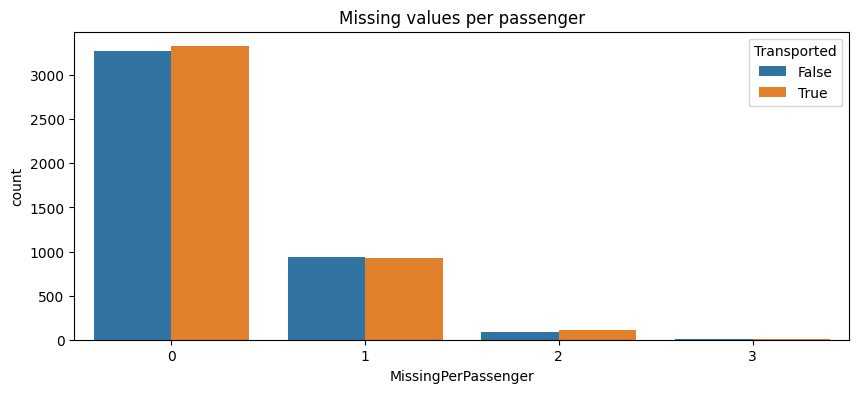

In [108]:
train_data['MissingPerPassenger'] = train_data.isna().sum(axis=1)
plt.figure(figsize=(10, 4))
sns.countplot(data=train_data, x=train_data['MissingPerPassenger'], hue='Transported')
plt.title('Missing values per passenger')
train_data.drop(columns=['MissingPerPassenger'], axis=1, inplace=True)

We're only missing around 2% of the values, but around 25% of passengers have at least one missing value.
The easiest way to handle them could be to use the media for numerical features and the mode for categorical features.
However, we will look at the joint distribution of missing values to see if there are patterns.

### Features creation

#### Compute spendings

In [109]:
# Compute total spendings and add it as a new feature 'TotalSpendings'
# Add a new feature 'hasSpent' which is True if the passenger has spent money in at least one of the categories
def compute_spendings(data: pd.DataFrame):
    data['TotalSpendings'] = data[exp_features].sum(axis=1)
    data['hasSpent'] = (data['TotalSpendings'] > 0)
    return data

#### Passenger groups

In [110]:
def create_groups(data: pd.DataFrame):
    data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    data['GroupSize'] = data.groupby('Group')['Group'].transform('count')
    data['IsAlone'] = (data['GroupSize'] == 1).astype(int)
    return data

#### Compute family size

In [ ]:
def compute_family_size(data: pd.DataFrame):
    data['Name'] = data['Name'].fillna('Unknown Unknown')
    data['LastName'] = data['Name'].str.split().str[-1]
    data['FamilySize'] = data.groupby('LastName')['LastName'].transform('count')

    data.loc[data['LastName'] == 'Unknown', 'LastName'] = np.nan
    data.loc[data['FamilySize'] > 100, 'FamilySize'] = np.nan

    data = data.drop('Name', axis=1)

In [112]:
def clean(data: pd.DataFrame):
    create_groups(data)
    compute_family_size(data)

    return data

cleaned_train_data = clean(train_data)
print(cleaned_train_data.head())
# cleaned_test_data = clean(test_data)

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa       NaN  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  Group  GroupSize  IsAlone     LastName  FamilySize  
0        False      1          1   

/var/folders/7k/xp2ftdcs1lbbqkgk6cymw2pm0000gn/T/ipykernel_7288/1405467770.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Name'].fillna('Unknown Unknown', inplace=True)


### Group by HomePlanet

In [17]:
# def group_by_homeplanet(data: pd.Dataframe):
#     data.groupby('HomePlanet').mean()

### Add total spending

In [18]:
# exp_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# def add_total_spending(df: pd.DataFrame):
# 	df['TotalSpending'] = df[exp_features].sum(axis=1)
# 	return df

### Fill missing CryoSleep and Spending values

In [19]:
# def fill_missing_cryo_and_spendings(df: pd.DataFrame):
#     df.loc[(df['CryoSleep'].isna()) & (df['TotalSpending'] > 0), 'CryoSleep'] = False
#     df.loc[(df['CryoSleep'].isna()) & (df['TotalSpending'] == 0), 'CryoSleep'] = True

#     # If CryoSleep is True, then all spending features should be 0
#     # If CrypoSleep is False, then we fill with median spending of non-cryo passengers
#     for feature in exp_features:
#         df.loc[(df[feature].isna()) & (df['CryoSleep'] == True), feature] = 0
#         median_value = df.loc[df['CryoSleep'] == False, feature].median()
#         df.loc[(df[feature].isna()) & (df['CryoSleep'] == False), feature] = median_value
#     return df

In [20]:
# def clean(data: pd.DataFrame):
#     data = data.drop([
#         'PassengerId',
#         'Cabin',
#         'Name',
#         'HomePlanet',
#         'Destination',
#         'Age',
#         'VIP',
#     ], axis=1)

#     data = add_total_spending(data)
#     data = fill_missing_cryo_and_spendings(data)

#     return data

# cleaned_train_data = clean(train_data)
# print(cleaned_train_data.isna().sum())
# cleaned_test_data = clean(test_data)

## Display NA values before and after cleaning

In [21]:
# print(train_data.isna().sum())
# print("")
# print(cleaned_train_data.isna().sum())

## Model Simulation

In [ ]:
from sklearn.model_selection import cross_val_score

# Kaggle Score Simulation
print("\n" + "="*50)
print("KAGGLE SCORE SIMULATION")
print("="*50)

# Separate features and target
y = train_data['Transported']
X = train_data.drop('Transported', axis=1)

# Clean the data
X_cleaned = clean(X.copy())

# Handle remaining missing values and encode categorical variables
X_cleaned = X_cleaned.fillna(X_cleaned.median(numeric_only=True))
X_cleaned = pd.get_dummies(X_cleaned, drop_first=True)

# Cross-validation
model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
cv_scores = cross_val_score(model, X_cleaned, y, cv=5, scoring='accuracy')

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\n📊 Expected Kaggle Score Range: {cv_scores.mean() - cv_scores.std():.4f} - {cv_scores.mean() + cv_scores.std():.4f}")


KAGGLE SCORE SIMULATION
